In [17]:
import re
import os
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from stable_baselines.results_plotter import ts2xy
from stable_baselines.bench.monitor import load_results
from tqdm import tqdm
from collections import defaultdict
import matplotlib.ticker as plticker

import matplotlib.pyplot as plt
%matplotlib inline

# set up matplotlib

plt.ion()

In [2]:
test_dirs = ['logs/ppo2_scratch/', 'logs/mlap-ppo2/']
env = 'RoboschoolHopper-v1'
prefixes = ["1sources-3sets-1subopt-SIW", "1sources-3sets-SIW", "4sources-3sets-SIW", "4sources-3sets-2subopt-SIW", "4sources-3sets-4subopt-SIW", "8sources-3sets-SIW", ""]
save_path = "logs/{}_analysis/".format(env)

In [3]:
mean_reward = defaultdict(list)

for test_dir in test_dirs:
    for env_exp_id in tqdm(os.listdir(test_dir)):
        if env in env_exp_id:
            result_dir = os.path.join(test_dir, env_exp_id,'results/robustness_0/')
            
            for prefix in prefixes:
                if prefix in result_dir:
                    break
            if os.path.isdir(result_dir):      
                for result in os.listdir(result_dir):
                    if result[-4:] == '.csv':
                        mean = pd.read_csv(os.path.join(result_dir, result), header=0).to_dict()['mean_reward'][0]
                        name = '{}_{}_{}'.format(test_dir.split('/')[1], prefix, result[8:-4])
                        mean_reward[name].append(mean)
    

100%|██████████| 7837/7837 [08:17<00:00, 15.76it/s] 


In [4]:
def extract_numerics(name):
    digits = re.findall(r'\d+', name)
    floats = [float(n)/10 for n in digits]
    
    return floats

In [5]:
for key in mean_reward:
    mean_reward[key] = np.array(mean_reward[key])

In [29]:
df = {'Policy':[], 'Injected noise STD':[], 'Performance (%)':[], 'Noise type':[]}

for key in mean_reward:
    split_key = key.split('_')
    noise = extract_numerics('_'.join(split_key[-2:]))
    
    if max(noise) == 0:
        continue
    
    
    policy = '_'.join(split_key[:-2])
    
    try:
        df['Performance (%)'].append(np.mean(mean_reward[key] / mean_reward[policy+'_acNoise00_obNoise0']) * 100.0)
    except:
        print(key, len(mean_reward[key]), len( mean_reward[policy+'_acNoise00_obNoise0']))
        continue
        
    
    if 'scratch' in policy:
        df['Policy'].append('MLP')
    else:
        df['Policy'].append(policy)
    
    df['Injected noise STD'].append(max(noise))
    df['Noise type'].append('ACTION NOISE' if noise[0] == 0 else 'OBSERVATION NOISE')
    
    
df = pd.DataFrame(df)

ppo2_scratch__acNoise0_ob10Noise 102 300
ppo2_scratch__acNoise0_ob20Noise 102 300
ppo2_scratch__acNoise0_ob05Noise 102 300
ppo2_scratch__acNoise20_ob0Noise 102 300
ppo2_scratch__acNoise10_ob0Noise 102 300
ppo2_scratch__acNoise05_ob0Noise 102 300
ppo2_scratch__acNoise15_ob0Noise 102 300
ppo2_scratch__acNoise0_ob15Noise 102 300


In [24]:
df

,Policy,Injected noise STD,Performance (\%),Noise type
0,MLP,2.0,9.930284,OBSERVATION NOISE
1,MLP,2.0,17.323754,ACTION NOISE
2,MLP,1.0,19.128335,OBSERVATION NOISE
3,MLP,1.5,12.052597,OBSERVATION NOISE
4,MLP,1.5,23.606558,ACTION NOISE
5,MLP,0.5,49.138807,OBSERVATION NOISE
6,MLP,0.5,65.978219,ACTION NOISE
7,MLP,1.0,36.876599,ACTION NOISE
8,mlap-ppo2_1sources-3sets-SIW,2.0,7.032064,OBSERVATION NOISE
9,mlap-ppo2_1sources-3sets-SIW,1.0,18.499614,OBSERVATION NOISE


In [16]:
mean_reward.keys()

dict_keys(['ppo2_scratch__acNoise20_obNoise0', 'ppo2_scratch__acNoise0_obNoise20', 'ppo2_scratch__acNoise10_obNoise0', 'ppo2_scratch__acNoise15_obNoise0', 'ppo2_scratch__acNoise0_obNoise15', 'ppo2_scratch__acNoise05_obNoise0', 'ppo2_scratch__acNoise0_obNoise05', 'ppo2_scratch__acNoise00_obNoise0', 'ppo2_scratch__acNoise0_obNoise10', 'ppo2_scratch__acNoise0_ob10Noise', 'ppo2_scratch__acNoise0_ob20Noise', 'ppo2_scratch__acNoise0_ob05Noise', 'ppo2_scratch__acNoise20_ob0Noise', 'ppo2_scratch__acNoise10_ob0Noise', 'ppo2_scratch__acNoise05_ob0Noise', 'ppo2_scratch__acNoise15_ob0Noise', 'ppo2_scratch__acNoise0_ob15Noise', 'ppo2_scratch__acNoise00_ob0Noise', 'mlap-ppo2_1sources-3sets-SIW_acNoise20_obNoise0', 'mlap-ppo2_1sources-3sets-SIW_acNoise10_obNoise0', 'mlap-ppo2_1sources-3sets-SIW_acNoise05_obNoise0', 'mlap-ppo2_1sources-3sets-SIW_acNoise15_obNoise0', 'mlap-ppo2_1sources-3sets-SIW_acNoise0_obNoise05', 'mlap-ppo2_1sources-3sets-SIW_acNoise0_obNoise20', 'mlap-ppo2_1sources-3sets-SIW_acNoi

Text(0.5,1,'Action noise')

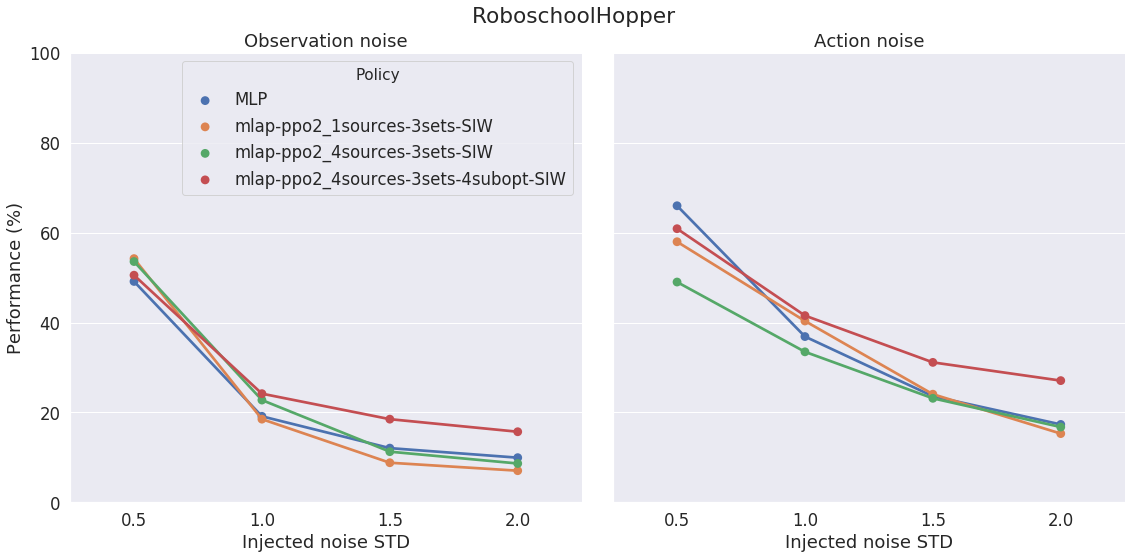

In [77]:
sns.set(style="whitegrid", font_scale=2)

ax = sns.catplot(x='Injected noise STD', y='Performance (%)', hue='Policy', kind='point', data=df, col='Noise type', height=8, sharey=True, legend_out=False)

plt.ylim([0, 100])
# ax.fig.suptitle(env[:-3])
# loc = plticker.MultipleLocator(base=20)

# ax.axes[0,0].set_major_locator(loc)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle(env[:-3])

ax.axes[0,0].set_title('Observation noise')
ax.axes[0,1].set_title('Action noise')

In [70]:
a=ax.axes[0][0]

In [ ]:
a.yaxis.

In [59]:
ax.fig.suptitle

Text(0.5,0.98,'RoboschoolHopper')

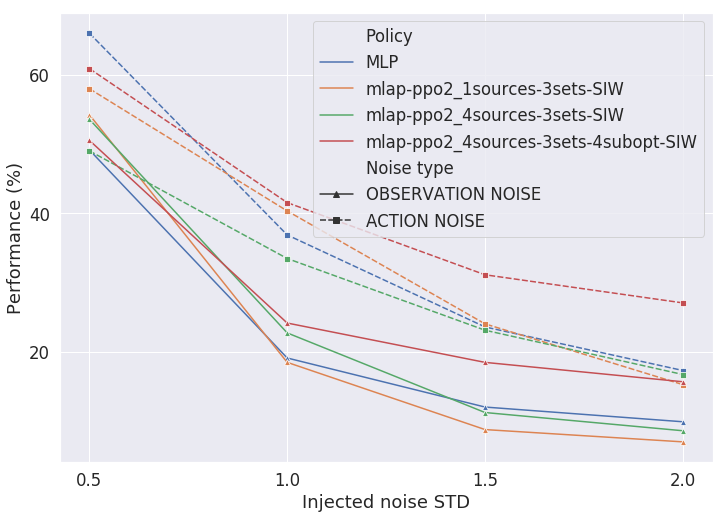

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="darkgrid", font_scale=1.5)
ax = sns.lineplot(x='Injected noise STD', y='Performance (%)', hue='Policy', data=df, style='Noise type', markers={'ACTION NOISE':'s', 'OBSERVATION NOISE': '^'}, legend='brief')
loc = plticker.MultipleLocator(base=0.5)
ax.xaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=20)
ax.yaxis.set_major_locator(loc)

In [28]:
df[df['Noise type'].isin(['ACTION NOISE'])]

,Policy,Injected noise STD,Performance,Noise type
0,ppo2_scratch_,1.5,6.443667,ACTION NOISE
1,ppo2_scratch_,0.5,23.915749,ACTION NOISE
3,ppo2_scratch_,2.0,4.601090,ACTION NOISE
7,ppo2_scratch_,1.0,11.602157,ACTION NOISE


In [34]:
?sns.catplot

Signature: sns.catplot(x=None, y=None, hue=None, data=None, row=None, col=None, col_wrap=None, estimator=<function mean at 0x7fec8427f6a8>, ci=95, n_boot=1000, units=None, order=None, hue_order=None, row_order=None, col_order=None, kind='strip', height=5, aspect=1, orient=None, color=None, palette=None, legend=True, legend_out=True, sharex=True, sharey=True, margin_titles=False, facet_kws=None, **kwargs)
Docstring:
Figure-level interface for drawing categorical plots onto a FacetGrid.

This function provides access to several axes-level functions that
show the relationship between a numerical and one or more categorical
variables using one of several visual representations. The ``kind``
parameter selects the underlying axes-level function to use:

Categorical scatterplots:

- :func:`stripplot` (with ``kind="strip"``; the default)
- :func:`swarmplot` (with ``kind="swarm"``)

Categorical distribution plots:

- :func:`boxplot` (with ``kind="box"``)
- :func:`violinplot` (with ``kind="violi